In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install panns-inference

Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

--2024-03-08 15:24:28--  http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/class_labels_indices.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.207, 108.177.125.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14675 (14K) [application/octet-stream]
Saving to: '/root/panns_data/class_labels_indices.csv'

     0K .......... ....                                       100% 52.4M=0s

2024-03-08 15:24:28 (52.4 MB/s) - '/root/panns_data/class_labels_indices.csv' saved [14675/14675]



In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display

In [3]:
# Get csv paths
path_csv_train = "/kaggle/input/dataset10/Dataset/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
path_csv_test = "/kaggle/input/dataset10/Dataset/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
path_csv_val = "/kaggle/input/dataset10/Dataset/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# Get spectrograms paths
path_spectro_train = "/kaggle/input/dataset10/Dataset/Selection morceaux audio 5s/Audible/train_spectro"
path_spectro_test = "/kaggle/input/dataset10/Dataset/Selection morceaux audio 5s/Audible/test_spectro"
path_spectro_val = "/kaggle/input/dataset10/Dataset/Selection morceaux audio 5s/Audible/val_spectro"

path_spectro = [path_spectro_train, path_spectro_test, path_spectro_val]

# Get audio path
path_train = "/kaggle/input/dataset10/Dataset/Selection morceaux audio 5s/Audible/train"
path_test = "/kaggle/input/dataset10/Dataset/Selection morceaux audio 5s/Audible/test"
path_val = "/kaggle/input/dataset10/Dataset/Selection morceaux audio 5s/Audible/val"

path_audio = [path_train, path_test, path_val]

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_csv_train)
df_test = pd.read_csv(path_csv_test)
df_val = pd.read_csv(path_csv_val)

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

def get_data_info(df):
    y = df['label']
    y_category = df['label_category']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_encoded = label_encoder.transform(y)
    
    # create new empty dataframe
    new_df = pd.DataFrame()

    new_df['label'] = y_encoded
    new_df['t1'] = df["annotation_initial_time"] - df["chunk_initial_time"]
    new_df['t2'] = df["annotation_final_time"] - df["chunk_initial_time"]
    new_df['f1'] = df['min_frequency'].astype(int)
    new_df['f2'] = df['max_frequency'].astype(int)
    code_unique = df['code_unique'] 
    str_to_add = '_split_' + df['chunk_initial_time'].astype(str) + '_' + df['chunk_final_time'].astype(str)
    new_df['filename'] = code_unique + str_to_add + '.png'
    new_df['sr'] = df['sampling_rate']
    new_df['duration_chunk'] = df['chunk_final_time'] - df['chunk_initial_time']
    new_df['label_class'] = y_class

    # Gestion des valeurs manquantes
    new_df = new_df.dropna()

    return new_df

info_train = get_data_info(df_train)
info_test = get_data_info(df_test)
info_val = get_data_info(df_val)

infos_data = [info_train, info_test, info_val]

In [5]:
# remove labels with sr == 384000
info_train = info_train[info_train['sr'] != 384000]
info_test = info_test[info_test['sr'] != 384000]
info_val = info_val[info_val['sr'] != 384000]

# correct the ids
info_train = info_train.reset_index(drop=True)
info_test = info_test.reset_index(drop=True)
info_val = info_val.reset_index(drop=True)

infos_data = [info_train, info_test, info_val]

info_train

,label,t1,t2,f1,f2,filename,sr,duration_chunk,label_class
0,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5,Insecta
1,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5,Insecta
2,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_10_15.png,44100,5,Insecta
3,60,0.000000,5.000000,7918,11211,Anura_XXXXigeXXES_01VII2022_335_split_0_5.png,44100,5,Insecta
4,60,0.000000,5.000000,7918,11211,Anura_XXXXigeXXES_01VII2022_335_split_5_10.png,44100,5,Insecta
...,...,...,...,...,...,...,...,...,...
8096,9,2.296621,3.300916,5007,16160,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
8097,9,4.691478,5.000000,4750,16553,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
8098,9,0.000000,0.674299,5416,17367,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5,Insecta
8099,9,3.399642,3.863163,5007,15776,Aves_KrDe_AwSw00PL_16VII2014_4613_split_180_18...,44100,5,Insecta


In [6]:
info_train2 = info_train[info_train['label_class'] != 'Insecta']
info_train3 = info_train2[info_train2['label_class'] != 'Aves']
info_train3

,label,t1,t2,f1,f2,filename,sr,duration_chunk,label_class
997,4,0.413518,1.180834,603,913,Orthoptera_lmestec81FR_12VII2022_324_split_20_...,96000,5,Mammalia
1329,4,4.469713,4.817130,332,1588,Orthoptera_meclcar09FR_20VII2023_1368_split_0_...,96000,5,Mammalia
1332,4,1.040389,1.291464,321,1449,Orthoptera_meclcar09FR_20VII2023_1368_split_5_...,96000,5,Mammalia
1484,4,4.444550,4.970709,479,663,Orthoptera_clcblau31FR_09VIII2022_500_split_10...,96000,5,Mammalia
1485,4,2.409407,2.627813,500,699,Orthoptera_clcblau31FR_09VIII2022_500_split_10...,96000,5,Mammalia
...,...,...,...,...,...,...,...,...,...
7856,3,0.000000,5.000000,403,1223,Anura_pechpuy46FR_11V2022_0345_split_15_20.png,48000,5,Amphibia
7858,3,0.000000,5.000000,403,1223,Anura_pechpuy46FR_11V2022_0345_split_20_25.png,48000,5,Amphibia
7861,3,0.000000,5.000000,403,1223,Anura_pechpuy46FR_11V2022_0345_split_25_30.png,48000,5,Amphibia
7863,3,0.000000,5.000000,403,1223,Anura_pechpuy46FR_11V2022_0345_split_30_35.png,48000,5,Amphibia


In [7]:
# prepare the data for the yolo dataset

# path to save the images and labels
path_yolo_dataset = "/kaggle/working/dataset2/Dataset/Selection morceaux audio 5s/Audible/Yolo"

# create the directory if it does not exist
if not os.path.exists(path_yolo_dataset):
    os.makedirs(path_yolo_dataset)

# create the subdirectories if they do not exist
os.makedirs(os.path.join(path_yolo_dataset, 'images'), exist_ok=True)
os.makedirs(os.path.join(path_yolo_dataset, 'labels'), exist_ok=True)
    
# Path to the destination images and labels
path_dest_images_train = os.path.join(path_yolo_dataset, 'images', 'train')
path_dest_labels_train = os.path.join(path_yolo_dataset, 'labels', 'train')
path_dest_images_test = os.path.join(path_yolo_dataset, 'images', 'test')
path_dest_labels_test = os.path.join(path_yolo_dataset, 'labels', 'test')
path_dest_images_val = os.path.join(path_yolo_dataset, 'images', 'val')
path_dest_labels_val = os.path.join(path_yolo_dataset, 'labels', 'val')

path_dest_images = [path_dest_images_train, path_dest_images_test, path_dest_images_val]
path_dest_labels = [path_dest_labels_train, path_dest_labels_test, path_dest_labels_val]

# Create the destination directories
for d in path_dest_images:
    os.makedirs(d, exist_ok=True)
for d in path_dest_labels:
    os.makedirs(d, exist_ok=True)

In [8]:
# add the images to the images directory

# Loop for train, test and val
for i in range(len(path_dest_images)):
    # List all files in the source directory
    files = os.listdir(path_spectro[i])

    # Copy images to the destination directory
    for file in files:
        if file.endswith('.png'):  # Change the extension if your images have a different format
            source_path = os.path.join(path_spectro[i], file)
            dest_path = os.path.join(path_dest_images[i], file)
            shutil.copy(source_path, dest_path)

In [9]:
# add labels to the label directory

# Loop for train, test and val
for i in range(len(path_dest_labels)):
    info_data = infos_data[i]
    for elt in tqdm(info_data.iterrows()):
        # get the row values
        index, row = elt
        filename = row['filename']
        t1 = row['t1']
        t2 = row['t2']
        f1 = row['f1']
        f2 = min(24000, row['f2'])
        label = row['label']
        chunk_duration = row['duration_chunk']
        
        # Get the image dimensions
        img = Image.open(os.path.join(path_spectro[i], filename))
        img_width, img_height = img.size
        
        # convert values to pixels
        t1_pixel = int(t1 * img_width/chunk_duration)
        t2_pixel = int(t2 * img_width/chunk_duration)
        f2_pixel = img_height - int(f1 * img_height/(48000/2))
        f1_pixel = img_height - int(f2 * img_height/(48000/2))
    
        # Normalize the coordinates
        t1_norm = t1_pixel/img_width
        t2_norm = t2_pixel/img_width
        f1_norm = f1_pixel/img_height
        f2_norm = f2_pixel/img_height
        
        # format : label x_center y_center width height
        x_center = (t1_norm + t2_norm)/2
        y_center = (f1_norm + f2_norm)/2
        width = t2_norm - t1_norm
        height = f2_norm - f1_norm
        
        # Create the label file
        label_file = filename.replace('.png', '.txt')
        
        # if the file already exists, we append the new bounding box
        if os.path.exists(os.path.join(path_dest_labels[i], label_file)):
            with open(os.path.join(path_dest_labels[i], label_file), 'a') as file:
                #if label == 2:
                    file.write(f"{label} {x_center} {y_center} {width} {height}\n")
                #else:
                 #   file.write(f"")
        else:
            with open(os.path.join(path_dest_labels[i], label_file), 'w') as file:
                #if label == 2:
                    file.write(f"{label} {x_center} {y_center} {width} {height}\n")
                #else:
                 #   file.write(f"")
                    

8101it [00:23, 340.81it/s]
1020it [00:01, 769.19it/s]
1055it [00:01, 729.69it/s]


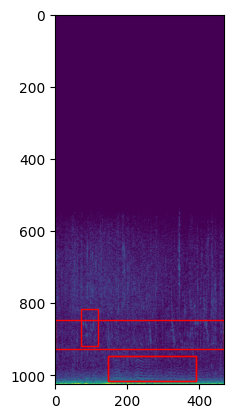

In [10]:
def draw_bounding_boxes(img_path, label_file):
    # Open the image
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # Read the label file
    with open(label_file, 'r') as file:
        lines = file.readlines()
        plt.imshow(img)
        for line in lines:
            label, x_center, y_center, width, height = map(float, line.split())
            img_width, img_height = img.size
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width/2)
            x2 = int(x_center + width/2)
            y1 = int(y_center - height/2)
            y2 = int(y_center + height/2)

            # Create a Rectangle patch
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            
    # Display the image with bounding boxes
    plt.show()

# test check
# get random id
id = random.randint(0, len(info_test))
img_path = os.path.join(path_dest_images_test, info_test.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_test, info_test.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)

In [11]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    #print(sorted_indexes)

    labels_detectes = {}
    # Print audio tagging top probabilities
    for k in range(10):
        noms_labels = np.array(labels)[sorted_indexes[k]]
        probas = clipwise_output[sorted_indexes[k]]
        #print('{}: {:.3f}'.format(noms_labels, probas))
        if probas >= 0.2 :
            labels_detectes[noms_labels] = probas
    #print(labels_detectes)
    return labels_detectes

In [12]:
def plot_sound_event_detection_result(framewise_output):
    """Visualization of sound event detection result. 

    Args:
      framewise_output: (time_steps, classes_num)
    """
    out_fig_path = 'results/sed_result.png'
    os.makedirs(os.path.dirname(out_fig_path), exist_ok=True)

    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:5]

    ix_to_lb = {i : label for i, label in enumerate(labels)}
    lines = []
    for idx in idxes:
        line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('Frames')
    plt.ylabel('Probability')
    plt.ylim(0, 1.)
    plt.savefig(out_fig_path)
    print('Save fig to {}'.format(out_fig_path))

In [13]:
new_info_train = info_train[info_train['label'] == 26]
new_info_train

,label,t1,t2,f1,f2,filename,sr,duration_chunk,label_class
1567,26,1.431685,5.000000,3840,21688,Orthoptera_plmarsa31FR_12V2023_1214_split_0_5.png,44100,5,Insecta
1569,26,3.754273,5.000000,4172,14969,Orthoptera_plmarsa31FR_12V2023_1217_split_0_5.png,44100,5,Insecta
1572,26,1.518582,2.699702,4091,14712,Orthoptera_plmarsa31FR_12V2023_1217_split_0_5.png,44100,5,Insecta
1573,26,0.000000,2.016414,4172,14969,Orthoptera_plmarsa31FR_12V2023_1217_split_5_10...,44100,5,Insecta
1575,26,2.262480,2.621034,4091,14969,Orthoptera_plmarsa31FR_12V2023_1217_split_5_10...,44100,5,Insecta
...,...,...,...,...,...,...,...,...,...
3642,26,0.000000,5.000000,3304,13401,Orthoptera_XXXXporXXES_30IV2022_118_split_80_8...,44100,5,Insecta
3643,26,0.000000,2.694523,3304,13401,Orthoptera_XXXXporXXES_30IV2022_118_split_85_8...,44100,3,Insecta
3644,26,0.000000,2.000000,4075,5133,Orthoptera_XXXXXXXXXFR_19IX2020_30_split_5_7.png,48000,2,Insecta
3645,26,0.000000,5.000000,3610,15236,Orthoptera_XXXXXXXXXFR_27VIII2021_28_split_0_5...,48000,5,Insecta


In [15]:
id = random.randint(0, len(new_info_train))
image_path = os.path.join(path_dest_images_train, new_info_train.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_train, new_info_train.iloc[id]['filename'].replace('.png', '.txt'))
audio_path = os.path.join(path_train, new_info_train.iloc[id]['filename'].replace('.png', '.wav'))

(audio, _) = librosa.core.load(audio_path, sr=48000, mono=True)
audio = audio[None, :]  # (batch_size, segment_samples)

In [16]:
with open(label_file, "r") as fichier:
    contenu = fichier.read()
    print(contenu)

51 0.5 0.6726829268292682 1.0 0.04975609756097554



  0%|          | 0/206 [00:00<?, ?it/s]

------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  0%|          | 1/206 [00:05<19:32,  5.72s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  1%|          | 2/206 [00:11<18:54,  5.56s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  1%|▏         | 3/206 [00:16<18:44,  5.54s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  2%|▏         | 4/206 [00:22<19:04,  5.66s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  2%|▏         | 5/206 [00:28<18:57,  5.66s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  3%|▎         | 6/206 [00:33<18:47,  5.64s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  3%|▎         | 7/206 [00:39<18:40,  5.63s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  4%|▍         | 8/206 [00:45<18:34,  5.63s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  4%|▍         | 9/206 [00:50<18:26,  5.61s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  5%|▍         | 10/206 [00:56<18:31,  5.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  5%|▌         | 11/206 [01:01<18:17,  5.63s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  6%|▌         | 12/206 [01:07<18:13,  5.64s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  6%|▋         | 13/206 [01:13<18:03,  5.62s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  7%|▋         | 14/206 [01:18<18:01,  5.63s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  7%|▋         | 15/206 [01:24<17:53,  5.62s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  8%|▊         | 16/206 [01:30<18:02,  5.70s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  8%|▊         | 17/206 [01:35<17:53,  5.68s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  9%|▊         | 18/206 [01:41<17:43,  5.66s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


  9%|▉         | 19/206 [01:47<17:39,  5.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 10%|▉         | 20/206 [01:52<17:30,  5.65s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 10%|█         | 21/206 [01:58<17:28,  5.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 11%|█         | 22/206 [02:04<17:23,  5.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 11%|█         | 23/206 [02:09<17:18,  5.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 12%|█▏        | 24/206 [02:15<17:13,  5.68s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 12%|█▏        | 25/206 [02:21<17:07,  5.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 13%|█▎        | 26/206 [02:26<17:01,  5.68s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 13%|█▎        | 27/206 [02:32<17:03,  5.72s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 14%|█▎        | 28/206 [02:38<16:57,  5.72s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 14%|█▍        | 29/206 [02:44<16:51,  5.72s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 15%|█▍        | 30/206 [02:49<16:45,  5.71s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 15%|█▌        | 31/206 [02:55<16:38,  5.70s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 16%|█▌        | 32/206 [03:01<16:34,  5.71s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 16%|█▌        | 33/206 [03:07<16:27,  5.71s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 17%|█▋        | 34/206 [03:12<16:19,  5.70s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 17%|█▋        | 35/206 [03:18<16:15,  5.70s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 17%|█▋        | 36/206 [03:23<15:45,  5.56s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 18%|█▊        | 37/206 [03:29<15:44,  5.59s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 18%|█▊        | 38/206 [03:35<15:57,  5.70s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 19%|█▉        | 39/206 [03:40<15:53,  5.71s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 19%|█▉        | 40/206 [03:46<15:48,  5.71s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 20%|█▉        | 41/206 [03:52<15:43,  5.72s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 20%|██        | 42/206 [03:58<15:40,  5.73s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 21%|██        | 43/206 [04:04<15:43,  5.79s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 21%|██▏       | 44/206 [04:09<15:37,  5.79s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 22%|██▏       | 45/206 [04:15<15:32,  5.79s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 22%|██▏       | 46/206 [04:21<15:12,  5.70s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 23%|██▎       | 47/206 [04:27<15:11,  5.73s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 23%|██▎       | 48/206 [04:32<15:08,  5.75s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 24%|██▍       | 49/206 [04:38<15:08,  5.79s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 24%|██▍       | 50/206 [04:44<15:04,  5.79s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 25%|██▍       | 51/206 [04:50<14:57,  5.79s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 25%|██▌       | 52/206 [04:56<14:49,  5.78s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 26%|██▌       | 53/206 [05:01<14:44,  5.78s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 26%|██▌       | 54/206 [05:07<14:43,  5.81s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 27%|██▋       | 55/206 [05:13<14:35,  5.80s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 27%|██▋       | 56/206 [05:19<14:29,  5.80s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 28%|██▊       | 57/206 [05:25<14:24,  5.80s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 28%|██▊       | 58/206 [05:31<14:33,  5.90s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 29%|██▊       | 59/206 [05:37<14:25,  5.89s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 29%|██▉       | 60/206 [05:42<14:18,  5.88s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 30%|██▉       | 61/206 [05:48<14:09,  5.86s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 30%|███       | 62/206 [05:54<13:58,  5.82s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 31%|███       | 63/206 [06:00<13:50,  5.81s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 31%|███       | 64/206 [06:06<13:45,  5.81s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 32%|███▏      | 65/206 [06:11<13:45,  5.85s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 32%|███▏      | 66/206 [06:17<13:39,  5.85s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 33%|███▎      | 67/206 [06:23<13:34,  5.86s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 33%|███▎      | 68/206 [06:29<13:27,  5.85s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 33%|███▎      | 69/206 [06:35<13:25,  5.88s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 34%|███▍      | 70/206 [06:41<13:30,  5.96s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 34%|███▍      | 71/206 [06:47<13:21,  5.94s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 35%|███▍      | 72/206 [06:53<13:11,  5.91s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 35%|███▌      | 73/206 [06:59<13:04,  5.90s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 36%|███▌      | 74/206 [07:05<12:58,  5.90s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 36%|███▋      | 75/206 [07:11<12:51,  5.89s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 37%|███▋      | 76/206 [07:16<12:47,  5.90s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 37%|███▋      | 77/206 [07:22<12:40,  5.89s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 38%|███▊      | 78/206 [07:28<12:36,  5.91s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 38%|███▊      | 79/206 [07:34<12:11,  5.76s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 39%|███▉      | 80/206 [07:40<12:10,  5.80s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 39%|███▉      | 81/206 [07:46<12:12,  5.86s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 40%|███▉      | 82/206 [07:52<12:09,  5.88s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 40%|████      | 83/206 [07:57<12:04,  5.89s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 41%|████      | 84/206 [08:03<12:00,  5.90s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 41%|████▏     | 85/206 [08:09<11:58,  5.94s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 42%|████▏     | 86/206 [08:16<12:00,  6.00s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 42%|████▏     | 87/206 [08:22<11:53,  6.00s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 43%|████▎     | 88/206 [08:28<11:48,  6.01s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 43%|████▎     | 89/206 [08:33<11:40,  5.99s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 44%|████▎     | 90/206 [08:40<11:36,  6.00s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 44%|████▍     | 91/206 [08:46<11:31,  6.01s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 45%|████▍     | 92/206 [08:52<11:25,  6.01s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 45%|████▌     | 93/206 [08:58<11:19,  6.02s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 46%|████▌     | 94/206 [09:04<11:13,  6.01s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 46%|████▌     | 95/206 [09:10<11:05,  6.00s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 47%|████▋     | 96/206 [09:16<11:00,  6.01s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 47%|████▋     | 97/206 [09:22<11:03,  6.08s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 48%|████▊     | 98/206 [09:28<10:54,  6.06s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 48%|████▊     | 99/206 [09:34<10:46,  6.05s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 49%|████▊     | 100/206 [09:40<10:39,  6.03s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 49%|████▉     | 101/206 [09:46<10:32,  6.02s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 50%|████▉     | 102/206 [09:51<10:06,  5.83s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 50%|█████     | 103/206 [09:57<10:05,  5.88s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 50%|█████     | 104/206 [10:03<10:00,  5.89s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 51%|█████     | 105/206 [10:09<09:58,  5.93s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 51%|█████▏    | 106/206 [10:15<09:56,  5.96s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 52%|█████▏    | 107/206 [10:21<09:53,  5.99s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 52%|█████▏    | 108/206 [10:27<09:50,  6.02s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 53%|█████▎    | 109/206 [10:33<09:44,  6.03s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 53%|█████▎    | 110/206 [10:39<09:38,  6.03s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 54%|█████▍    | 111/206 [10:46<09:35,  6.06s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 54%|█████▍    | 112/206 [10:52<09:29,  6.06s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 55%|█████▍    | 113/206 [10:58<09:24,  6.07s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 55%|█████▌    | 114/206 [11:04<09:17,  6.06s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 56%|█████▌    | 115/206 [11:10<09:12,  6.07s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 56%|█████▋    | 116/206 [11:16<09:05,  6.06s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 57%|█████▋    | 117/206 [11:22<09:08,  6.17s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 57%|█████▋    | 118/206 [11:29<09:10,  6.25s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 58%|█████▊    | 119/206 [11:35<08:59,  6.21s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 58%|█████▊    | 120/206 [11:41<08:52,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 59%|█████▊    | 121/206 [11:47<08:45,  6.18s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 59%|█████▉    | 122/206 [11:53<08:37,  6.16s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 60%|█████▉    | 123/206 [12:00<08:37,  6.24s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 60%|██████    | 124/206 [12:06<08:29,  6.21s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 61%|██████    | 125/206 [12:12<08:22,  6.20s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 61%|██████    | 126/206 [12:18<08:16,  6.20s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 62%|██████▏   | 127/206 [12:24<08:08,  6.18s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 62%|██████▏   | 128/206 [12:31<08:04,  6.21s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 63%|██████▎   | 129/206 [12:37<07:57,  6.20s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 63%|██████▎   | 130/206 [12:43<07:51,  6.20s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 64%|██████▎   | 131/206 [12:49<07:44,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 64%|██████▍   | 132/206 [12:55<07:38,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 65%|██████▍   | 133/206 [13:02<07:31,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 65%|██████▌   | 134/206 [13:08<07:25,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 66%|██████▌   | 135/206 [13:14<07:19,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 66%|██████▌   | 136/206 [13:20<07:13,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 67%|██████▋   | 137/206 [13:26<07:06,  6.18s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 67%|██████▋   | 138/206 [13:33<07:04,  6.24s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 67%|██████▋   | 139/206 [13:38<06:46,  6.07s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 68%|██████▊   | 140/206 [13:44<06:42,  6.10s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 68%|██████▊   | 141/206 [13:51<06:38,  6.13s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 69%|██████▉   | 142/206 [13:57<06:33,  6.15s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 69%|██████▉   | 143/206 [14:03<06:33,  6.25s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 70%|██████▉   | 144/206 [14:10<06:27,  6.25s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 70%|███████   | 145/206 [14:16<06:21,  6.25s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 71%|███████   | 146/206 [14:22<06:14,  6.25s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 71%|███████▏  | 147/206 [14:28<06:10,  6.27s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 72%|███████▏  | 148/206 [14:35<06:08,  6.35s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 72%|███████▏  | 149/206 [14:41<06:00,  6.33s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 73%|███████▎  | 150/206 [14:48<05:53,  6.32s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 73%|███████▎  | 151/206 [14:54<05:46,  6.29s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 74%|███████▍  | 152/206 [15:00<05:35,  6.20s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 74%|███████▍  | 153/206 [15:06<05:29,  6.21s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 75%|███████▍  | 154/206 [15:12<05:21,  6.19s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 75%|███████▌  | 155/206 [15:18<05:14,  6.17s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 76%|███████▌  | 156/206 [15:25<05:11,  6.22s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 76%|███████▌  | 157/206 [15:31<05:04,  6.22s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 77%|███████▋  | 158/206 [15:37<05:00,  6.25s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 77%|███████▋  | 159/206 [15:44<04:55,  6.28s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 78%|███████▊  | 160/206 [15:50<04:49,  6.29s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 78%|███████▊  | 161/206 [15:56<04:43,  6.30s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 79%|███████▊  | 162/206 [16:02<04:37,  6.30s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 79%|███████▉  | 163/206 [16:09<04:31,  6.32s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 80%|███████▉  | 164/206 [16:16<04:30,  6.44s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 80%|████████  | 165/206 [16:21<04:13,  6.18s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 81%|████████  | 166/206 [16:27<04:08,  6.22s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 81%|████████  | 167/206 [16:34<04:04,  6.26s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 82%|████████▏ | 168/206 [16:40<03:59,  6.31s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 82%|████████▏ | 169/206 [16:47<03:54,  6.33s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 83%|████████▎ | 170/206 [16:53<03:47,  6.33s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 83%|████████▎ | 171/206 [16:59<03:42,  6.36s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 83%|████████▎ | 172/206 [17:06<03:36,  6.37s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 84%|████████▍ | 173/206 [17:12<03:30,  6.38s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 84%|████████▍ | 174/206 [17:19<03:24,  6.40s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 85%|████████▍ | 175/206 [17:25<03:18,  6.40s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 85%|████████▌ | 176/206 [17:31<03:11,  6.39s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 86%|████████▌ | 177/206 [17:38<03:05,  6.40s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 86%|████████▋ | 178/206 [17:44<03:00,  6.46s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 87%|████████▋ | 179/206 [17:51<02:53,  6.43s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 87%|████████▋ | 180/206 [17:57<02:47,  6.43s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 88%|████████▊ | 181/206 [18:04<02:40,  6.42s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 88%|████████▊ | 182/206 [18:10<02:33,  6.41s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 89%|████████▉ | 183/206 [18:17<02:29,  6.49s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 89%|████████▉ | 184/206 [18:23<02:22,  6.47s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 90%|████████▉ | 185/206 [18:30<02:15,  6.47s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 90%|█████████ | 186/206 [18:36<02:09,  6.49s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 91%|█████████ | 187/206 [18:43<02:03,  6.49s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 91%|█████████▏| 188/206 [18:49<01:57,  6.51s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 92%|█████████▏| 189/206 [18:56<01:50,  6.50s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 92%|█████████▏| 190/206 [19:02<01:43,  6.50s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 93%|█████████▎| 191/206 [19:09<01:37,  6.51s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 93%|█████████▎| 192/206 [19:15<01:31,  6.50s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 94%|█████████▎| 193/206 [19:22<01:24,  6.51s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 94%|█████████▍| 194/206 [19:28<01:17,  6.50s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 95%|█████████▍| 195/206 [19:35<01:11,  6.49s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 95%|█████████▌| 196/206 [19:41<01:04,  6.50s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 96%|█████████▌| 197/206 [19:48<00:58,  6.50s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 96%|█████████▌| 198/206 [19:54<00:52,  6.61s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 97%|█████████▋| 199/206 [20:01<00:46,  6.59s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 97%|█████████▋| 200/206 [20:07<00:39,  6.56s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 98%|█████████▊| 201/206 [20:14<00:32,  6.56s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 98%|█████████▊| 202/206 [20:21<00:26,  6.55s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 99%|█████████▊| 203/206 [20:27<00:19,  6.57s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


 99%|█████████▉| 204/206 [20:34<00:13,  6.55s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


100%|█████████▉| 205/206 [20:41<00:06,  6.67s/it]

Save fig to results/sed_result.png
------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.


100%|██████████| 206/206 [20:46<00:00,  6.05s/it]

Save fig to results/sed_result.png


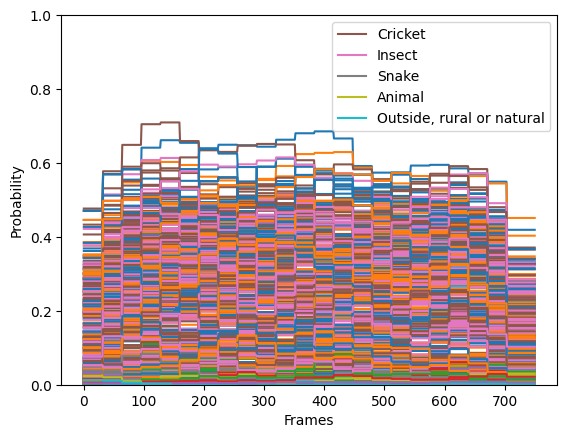

In [49]:
#draw_bounding_boxes(image_path, label_file)

#print_audio_tagging_result(clipwise_output[0])

#plot_sound_event_detection_result(framewise_output[0])

labels_detectes = {}

for i in tqdm(range(len(new_info_train))):
    image_path = os.path.join(path_dest_images_train, new_info_train.iloc[i]['filename'])
    label_file = os.path.join(path_dest_labels_train, new_info_train.iloc[i]['filename'].replace('.png', '.txt'))
    audio_path = os.path.join(path_train, new_info_train.iloc[i]['filename'].replace('.png', '.wav'))

    (audio, _) = librosa.core.load(audio_path, sr=48000, mono=True)
    audio = audio[None, :]  # (batch_size, segment_samples)
    
    #with open(label_file, "r") as fichier:
     #   contenu = fichier.read()
      #  print(contenu)
    
    print('------ Audio tagging ------')
    checkpoint = "/kaggle/working"
    at = AudioTagging(checkpoint_path=None, device='cuda')
    (clipwise_output, embedding) = at.inference(audio)
    
    detectes = print_audio_tagging_result(clipwise_output[0])
    for key, value in detectes.items():
        if key in labels_detectes:
            # Si la clé existe déjà dans dict1, on ajoute la valeur de dict2 à une liste
            if not isinstance(labels_detectes[key], list):
                labels_detectes[key] = [labels_detectes[key]]
            labels_detectes[key].append(value)
        else:
            # Si la clé n'existe pas dans dict1, on l'ajoute directement
            labels_detectes[key] = value
    
    print('------ Sound event detection ------')
    sed = SoundEventDetection(checkpoint_path=None, device='cuda')
    framewise_output = sed.inference(audio)
    
    plot_sound_event_detection_result(framewise_output[0])

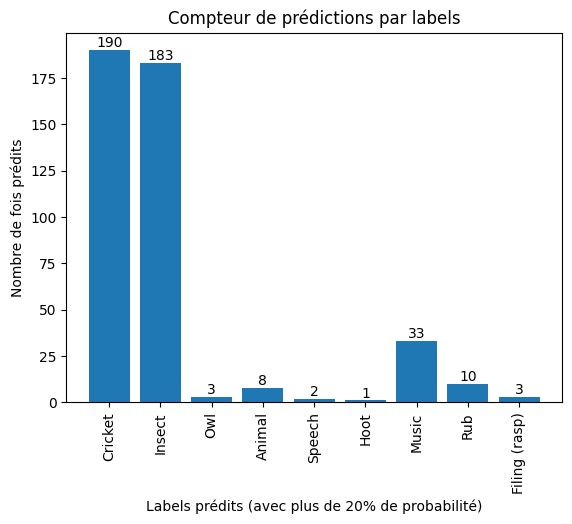

In [50]:
keys = list(labels_detectes.keys())
values = list(labels_detectes.values())

nb_values = []

for item in values:
    if isinstance(item, list):
        nb_values.append(len(item))  # Si c'est une liste, utilisez len()
    elif isinstance(item, np.ndarray):
        nb_values.append(item.size)  # Si c'est un tableau NumPy, utilisez .size
    else:
        nb_values.append(1)  # Par défaut, considérez-le comme un élément unique

bars = plt.bar(keys, nb_values)

# Ajouter des labels et un titre
plt.xlabel('Labels prédits (avec plus de 20% de probabilité)')
plt.ylabel('Nombre de fois prédits')
plt.title('Compteur de prédictions par labels')

plt.xticks(rotation=90)

for bar, value in zip(bars, nb_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), va='bottom', ha='center')

# Afficher le graphique
plt.show()

In [51]:
liste = labels_detectes['Cricket']
mean = np.mean(liste)
print("Moyenne sur le label cible : " + str(mean))

Moyenne sur le label cible : 0.6295287
